In [1]:
# Imports
import numpy as np
import math
from scipy.stats import pearsonr
import matplotlib.pyplot as plt

from openbabel import openbabel
openbabel.OBMessageHandler().SetOutputLevel(0)
openbabel.obErrorLog.SetOutputLevel(0)

from rdkit import Chem
from rdkit import RDLogger
lg = RDLogger.logger()
lg.setLevel(RDLogger.ERROR)

import molgrid
import torch
from models.default2018_model import default2018_Net
from models.gnina_dense_model import Dense

In [2]:
# Example
data_path = './data/LEADS_FRAGS'
idx = '1QY2'

In [3]:
seed=42

## Dock with smina

In [4]:
!./smina.static -r "{data_path}/{idx}/{idx}_receptor.mol2" -l "{data_path}/{idx}/{idx}_ligand.mol2" --autobox_ligand "{data_path}/{idx}/{idx}_ref-ligand.pdb" --autobox_add 24 -o "{data_path}/{idx}/{idx}_docked.sdf" --exhaustiveness 64 --num_modes 40 --seed {seed}

   _______  _______ _________ _        _______ 
  (  ____ \(       )\__   __/( (    /|(  ___  )
  | (    \/| () () |   ) (   |  \  ( || (   ) |
  | (_____ | || || |   | |   |   \ | || (___) |
  (_____  )| |(_)| |   | |   | (\ \) ||  ___  |
        ) || |   | |   | |   | | \   || (   ) |
  /\____) || )   ( |___) (___| )  \  || )   ( |
  \_______)|/     \|\_______/|/    )_)|/     \|


smina is based off AutoDock Vina. Please cite appropriately.

Weights      Terms
-0.035579    gauss(o=0,_w=0.5,_c=8)
-0.005156    gauss(o=3,_w=2,_c=8)
0.840245     repulsion(o=0,_c=8)
-0.035069    hydrophobic(g=0.5,_b=1.5,_c=8)
-0.587439    non_dir_h_bond(g=-0.7,_b=0,_c=8)
1.923        num_tors_div

Using random seed: 42

0%   10   20   30   40   50   60   70   80   90   100%
|----|----|----|----|----|----|----|----|----|----|
***************************************************

mode |   affinity | dist from best mode
     | (kcal/mol) | rmsd l.b.| rmsd u.b.
-----+------------+----------+----------
1       

Text(0, 0.5, 'RMSD')

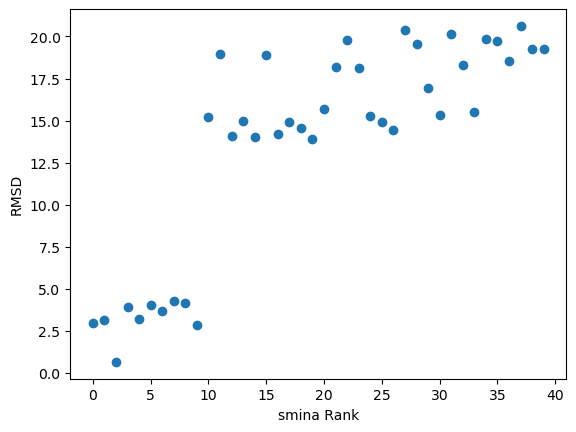

In [5]:
# Get RMSDs
from rmsd_utils import robust_rmsd

ref_mol = Chem.MolFromPDBFile(f'{data_path}/{idx}/{idx}_ref-ligand.pdb', removeHs=False)
docked_mols = Chem.SDMolSupplier(f'{data_path}/{idx}/{idx}_docked.sdf')

rmsds = []
for mol in docked_mols:
    rmsds.append(robust_rmsd(mol, ref_mol))

plt.scatter(range(len(rmsds)), rmsds)
plt.xlabel('smina Rank')
plt.ylabel('RMSD')

## Rerank with gnina

In [6]:
# Fix seeds
molgrid.set_random_seed(seed)
torch.manual_seed(seed)
np.random.seed(seed)

# Set CuDNN options for reproducibility
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [7]:
# Prepare .types file (note gnina needs separate SDF per molecule)
docked_mols = Chem.SDMolSupplier(f'{data_path}/{idx}/{idx}_docked.sdf')

with open(f'tmp_types_{idx}.types', 'w') as f:
    for i, (mol, rmsd) in enumerate(zip(docked_mols, rmsds)):
        if mol is None: 
            continue
        # Write types file
        f.write(f'{rmsd<=2:d} {rmsd:.2f} {data_path}/{idx}/{idx}_receptor.mol2 {data_path}/{idx}/{idx}_docked_{i}.sdf\n')
        # Save mol as separate file
        with Chem.SDWriter(f'{data_path}/{idx}/{idx}_docked_{i}.sdf') as writer:
            writer.write(mol)

In [8]:
# Helper function to get predictions and labels
def get_predictions_gnina(model, test_file, label_idx=1, pred_idx=-1, batch_size=32, data_root='./'):
    ypred_test, y_test = [], []
    model.eval()
    with torch.no_grad():
        e_test = molgrid.ExampleProvider(data_root=data_root,balanced=False,shuffle=False)
        e_test.populate(test_file)
        gmaker = molgrid.GridMaker()
        dims = gmaker.grid_dimensions(e_test.num_types())
        tensor_shape = (batch_size,)+dims
        input_tensor = torch.zeros(tensor_shape, dtype=torch.float32, device='cuda')
        float_labels = torch.zeros(batch_size, dtype=torch.float32)
        
        num_samples = e_test.size()
        num_batches = -(-num_samples // batch_size)
        for _ in range(num_batches):
            # Load data
            batch = e_test.next_batch(batch_size)
            batch.extract_label(label_idx, float_labels)
            gmaker.forward(batch, input_tensor, random_rotation=False, random_translation=0.0)
            # Get prediction
            output = model(input_tensor)[pred_idx].detach().cpu().numpy().reshape(-1)
            ypred_test.extend(list(output))
            # Get labels
            y_test.extend(list(float_labels.detach().cpu().numpy()))
    ypred_test = np.array(ypred_test)[:num_samples]
    y_test = np.array(y_test)[:num_samples]
    return ypred_test, y_test

In [9]:
dims = (28, 48, 48, 48)
model_name = './models/crossdock_default2018.pt'
model = default2018_Net(dims).to('cuda')
model.load_state_dict(torch.load(model_name))

# Get predictions (pred_idx=0 for pose score, pred_idx=1 for affinity score)
preds, labels = get_predictions_gnina(model, f'tmp_types_{idx}.types', label_idx=1, pred_idx=0, data_root='./')

In [10]:
# Assess performance
print(f'Success possible: {min(rmsds)<=2}')
if min(rmsds)<=2:
    print(f'\tsmina first success: {np.argmax(np.array(rmsds)<=2)+1}')
    print(f'\tgnina first success: {np.argmax(np.array([l for _, l in sorted(zip(preds, labels), reverse=True)])<=2)+1}')

Success possible: True
	smina first success: 3
	gnina first success: 1
